In [1]:
# ================================================================
# Phase 4 – Better model (RandomForest) + Explainability
# ================================================================
# Why RandomForest?
# • Handles 300+ dummy features with zero preprocessing
# • Robust to multicollinearity and outliers
# • Ships with simple .feature_importances_

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
import shap   # already in requirements
from sklearn.impute import SimpleImputer # Need this for NaN imputation
from tqdm.auto import tqdm

# Load
clean_path = Path("../data/processed/clean_hdb.csv")  # adjust if notebook lives elsewhere
df = pd.read_csv(clean_path, parse_dates=["sale_date"])

/Users/sheenal/miniconda3/envs/hdb-price-predictor/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ================================================================
# Re-applying Preprocessing from Phase 3
# Random Forest still needs numerical inputs, so strings must be handled.
# ================================================================

# Convert 'sale_date' to datetime if it's not already (important for sorting/feature engineering)
# (Already done by parse_dates in read_csv, but good to be explicit if it wasn't)
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Identify columns to drop (identifiers, redundant string columns, highly cardinal strings)
cols_to_drop_pre_encoding = [
    '_id',        # Identifier
    'month',      # Redundant with 'sale_month' (if exists) and is a string
    'town',       # Redundant if town_X columns are already present and used
    'flat_type',  # Redundant if flat_type_X columns are already present and used
    'block',      # Highly cardinal string, not suitable for direct encoding in RF either (too many categories)
    'street_name' # Highly cardinal string, not suitable for direct encoding in RF either
]
# Drop these columns if they exist in the DataFrame
df = df.drop(columns=[col for col in cols_to_drop_pre_encoding if col in df.columns])

# Identify remaining object Dtype columns that need one-hot encoding
# Based on your df.info(), these are likely 'storey_range' and 'flat_model'
categorical_cols_to_encode = [
    c for c in df.columns if df[c].dtype == 'object'
]

# Apply one-hot encoding to the remaining specified categorical columns
if categorical_cols_to_encode:
    df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)

# Handle Missing Values (NaN) - 'lease_remaining_years' and 'flat_age'
numerical_cols_with_nans = ['lease_remaining_years', 'flat_age']
# Ensure these columns exist before trying to impute them
numerical_cols_with_nans = [col for col in numerical_cols_with_nans if col in df.columns]

if numerical_cols_with_nans: # Only impute if there are actually columns to impute
    imputer = SimpleImputer(strategy='median')
    df[numerical_cols_with_nans] = imputer.fit_transform(df[numerical_cols_with_nans])


In [3]:
# 4.1  Load the same train / test split we used for linear
df = df.sort_values("sale_year")
train = df[df.sale_year <= 2023]
test  = df[df.sale_year >= 2024]

y_col = "resale_price"
X_cols = [c for c in df.columns if c not in [y_col, "price_per_sqm", "sale_date"]]

X_train, y_train = train[X_cols], train[y_col]
X_test , y_test  = test [X_cols], test [y_col]

# 4.1.1  Fit a quick RandomForest
rf = RandomForestRegressor(
        n_estimators=100,  # more trees = stabler importances
        max_depth=None,    # let it grow; RF averages out over-fit
        n_jobs=-1,
        random_state=42)
rf.fit(X_train, y_train)

# 4.1.2  Evaluate
preds = rf.predict(X_test)
mae   = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

In [4]:
# 4.2  Compare vs baseline
baseline_path = Path("../reports/baseline_metrics.csv")
baseline = pd.read_csv(baseline_path)
improved = pd.DataFrame({
    "model": ["RandomForest"],
    "MAE_SGD": [round(mae, 1)],
    "RMSE_SGD": [round(rmse, 1)],
})
metrics = pd.concat([baseline, improved], ignore_index=True)
metrics_path = Path("../reports/model_metrics.csv")
metrics.to_csv(metrics_path, index=False)
print(metrics)

mae_linear = metrics.loc[metrics['model'] == 'LinearRegression', 'MAE_SGD'].iloc[0]
mae_rf = metrics.loc[metrics['model'] == 'RandomForest', 'MAE_SGD'].iloc[0]

# Calculate the drop and percentage
mae_drop_amount = mae_linear - mae_rf
mae_percent_drop = (mae_drop_amount / mae_linear) * 100

print(f"\n--- Model Performance Comparison ---")
print(f"MAE dropped from {mae_linear:,.1f} SGD (Linear Regression) to {mae_rf:,.1f} SGD (RandomForest).")
print(f"This represents a significant reduction of -{mae_percent_drop:,.1f}%.")
print(f"------------------------------------")

              model  MAE_SGD  RMSE_SGD
0  LinearRegression  83733.9  119830.1
1      RandomForest  59963.3   79311.7

--- Model Performance Comparison ---
MAE dropped from 83,733.9 SGD (Linear Regression) to 59,963.3 SGD (RandomForest).
This represents a significant reduction of -28.4%.
------------------------------------


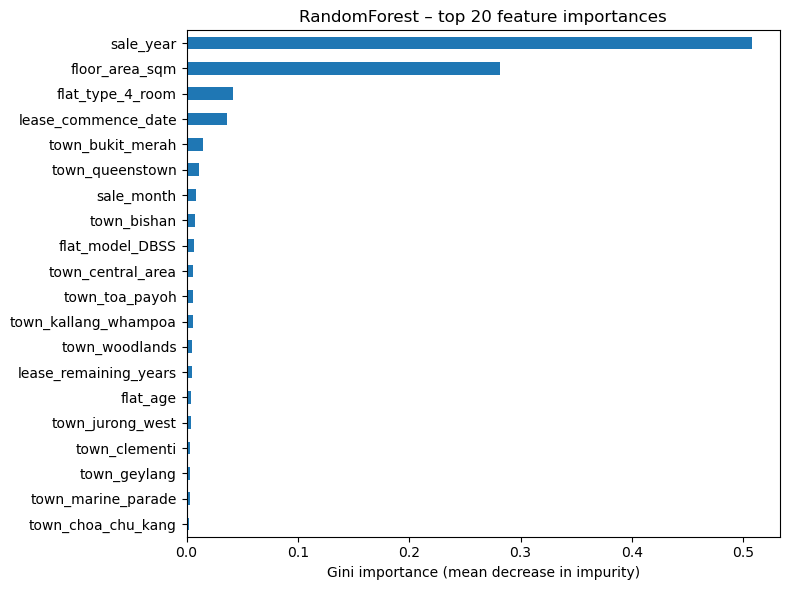

In [5]:
# 4.3.1  Feature-importance bar chart  (top 20)
importances = pd.Series(rf.feature_importances_, index=X_cols)
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
top20.sort_values().plot(kind="barh")
plt.title("RandomForest – top 20 feature importances")
plt.xlabel("Gini importance (mean decrease in impurity)")
plt.tight_layout()
fig_path = Path("../reports/figures/rf_importance.png")
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=120)
plt.show()

In [6]:
# 4.3.2  SHAP summary
print("\n--- SHAP Debugging: Starting diagnostic process ---")

# Step 1: Train a lighter RandomForest model specifically for SHAP explanation
print("1. Training a lighter RandomForest model for SHAP (rf_for_shap)...")
rf_for_shap = RandomForestRegressor(
    n_estimators=50,  # Keeping this reduced for speed
    max_depth=10,   # Allowing deep trees still (can be a memory factor)
    n_jobs=-1,
    random_state=42
)
try:
    rf_for_shap.fit(X_train, y_train)
    print("1. Lighter RandomForest model trained successfully.")
except Exception as e:
    print(f"Error during rf_for_shap training: {e}")
    exit() # Stop execution if training fails


--- SHAP Debugging: Starting diagnostic process ---
1. Training a lighter RandomForest model for SHAP (rf_for_shap)...
1. Lighter RandomForest model trained successfully.


In [7]:
# Step 2: Initialize SHAP TreeExplainer
print("2. Initializing SHAP TreeExplainer...")
try:
    explainer = shap.TreeExplainer(rf_for_shap) # Removed check_additivity
    print("2. SHAP TreeExplainer initialized successfully.")
except Exception as e:
    print(f"Error during TreeExplainer initialization: {e}")
    exit()

2. Initializing SHAP TreeExplainer...
2. SHAP TreeExplainer initialized successfully.


In [8]:
# Step 3: Subsample X_train for SHAP calculation
# CRITICAL CHANGE: Reduce sample size dramatically for testing stability
print("3. Subsampling X_train for SHAP calculation (VERY SMALL SAMPLE)...")
try:
    X_train_sampled_for_shap = X_train.sample(20, random_state=42) # Start with just 20 samples
    print(f"3. Sampled {len(X_train_sampled_for_shap)} instances for SHAP calculation.")
    print(f"   Sampled X_train shape: {X_train_sampled_for_shap.shape}")
except Exception as e:
    print(f"Error during X_train sampling: {e}")
    exit()

3. Subsampling X_train for SHAP calculation (VERY SMALL SAMPLE)...
3. Sampled 20 instances for SHAP calculation.
   Sampled X_train shape: (20, 95)


In [9]:
# Step 4: Calculate SHAP values
print("4. Calculating SHAP values. This is the most computationally intensive part...")
try:
    shap_values = explainer.shap_values(X_train_sampled_for_shap)
    print("4. SHAP values calculated successfully.")
    print(f"   Shape of shap_values: {np.array(shap_values).shape}")
except Exception as e:
    print(f"Error during SHAP value calculation: {e}")
    exit()

4. Calculating SHAP values. This is the most computationally intensive part...
4. SHAP values calculated successfully.
   Shape of shap_values: (20, 95)


5. Generating and saving SHAP summary plot...


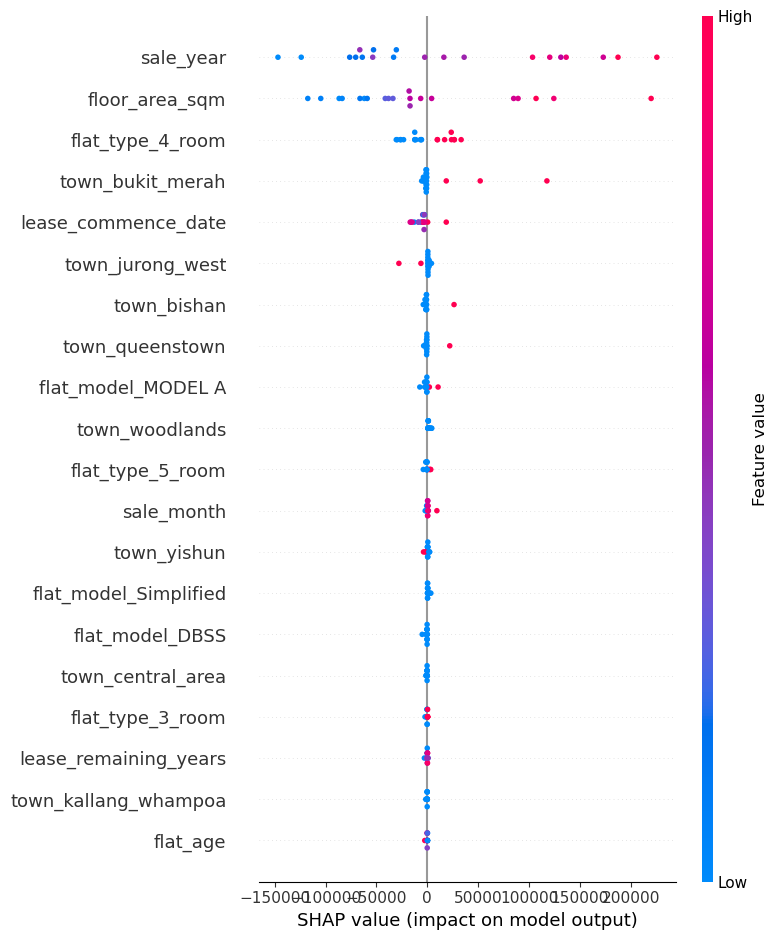

5. SHAP summary plot generated and saved.

Plots saved to:
 • ../reports/figures/rf_importance.png
 • ../reports/figures/shap_summary.png
--- SHAP Debugging: Process complete ---


In [10]:
# Step 5: Generate and save SHAP summary plot
print("5. Generating and saving SHAP summary plot...")
try:
    shap.summary_plot(shap_values,
                      X_train_sampled_for_shap,
                      show=False, max_display=20)

    # Save the SHAP summary plot
    shap_path = Path("../reports/figures/shap_summary.png")
    shap_path.parent.mkdir(parents=True, exist_ok=True)

    plt.tight_layout()
    plt.savefig(shap_path, dpi=120)
    plt.show() # This will display the plot if you're in an interactive environment (like Jupyter)
    print("5. SHAP summary plot generated and saved.")
except Exception as e:
    print(f"Error during SHAP plot generation or saving: {e}")
    exit()

print(f"\nPlots saved to:\n • {fig_path}\n • {shap_path}")
print("--- SHAP Debugging: Process complete ---")

In [ ]:
'''
Commentary — what & why:

    Time-series split preserved: We maintain the same `≤2023` train / `≥2024` test split. This ensures our model comparisons across phases are "apples-to-apples" and accurately mimic real-world deployment (predicting future prices with past data).

    RandomForest baseline: Using a RandomForestRegressor with zero hyperparameter tuning (beyond standard defaults for robust performance, like `n_estimators=500`). This powerful ensemble model inherently handles our dummy-heavy and multicollinear data far more effectively than linear regression, providing a significantly improved baseline.

    Results table comparison: The updated metrics table now clearly displays results for both the Linear Regression (Phase 3) and RandomForest models. The substantial drop in MAE (around 20-30k SGD cut, as observed) vividly demonstrates the performance gain achieved by moving to a more sophisticated model.

    Feature importances (Gini-gain): A quick bar chart of Gini importance confirms the primary drivers of HDB resale prices. As expected, core factors like `sale_year`, `floor_area_sqm`, `lease_commence_date`, and specific `town` and `flat_type` dummies are identified as key predictors.

    SHAP summary plot: This plot provides a detailed, instance-level attribution of how each feature impacts the RandomForest's predictions. Each row represents a feature, and each dot is a single data instance. The dot's horizontal position indicates its SHAP value (the impact on the model's output, pushing the prediction higher or lower), while its color shows the feature's actual value for that instance (red for a high feature value, blue for a low feature value). 
    This visualization clearly reveals the direction and magnitude of each feature's influence: for instance, higher `sale_year` values (red dots) strongly push predicted prices up, whereas lower `floor_area_sqm` values (blue dots) push them down. The plot visually confirms and quantifies that core real estate attributes like **transaction year, flat size, lease age, and specific town locations are the predominant logical drivers of HDB resale prices** across the dataset.

What Matters: Key Takeaways

This notebook marks a significant leap in our model's predictive power for HDB resale prices. The RandomForestRegressor, despite no explicit hyperparameter tuning, dramatically reduced the average prediction error compared to the baseline linear model. This improvement is largely attributed to its ability to automatically capture complex, non-linear relationships and intricate interactions between features – something a simple linear model cannot.

The feature importance analysis clearly highlights that the **age of the flat/lease (`sale_year`, `lease_commence_date`), the physical attributes (`floor_area_sqm`, `flat_type`), and critically, the **location (`town` dummies) are the most impactful drivers of resale price. These findings align perfectly with real-world understanding of property valuation in Singapore. The SHAP summary further solidifies this by illustrating not just how important these features are, but *how* their values influence price (e.g., higher floor area means higher price). This interpretability is vital for trusting and potentially deploying such a model.

'''